In [ ]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import skimage
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
w, h = 992,400
border = 5

In [3]:
ids = next(os.walk("spectrograms_clean"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  707


# **Data Reading and Train test split**

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')


In [5]:
import glob
train = sorted(glob.glob("spectrograms_clean/*"))
train_mask = sorted(glob.glob("spectrograms_noisy/*.png"))[:]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 707
Total Mask Image : 707


In [6]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [7]:
from tqdm import tqdm

In [8]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

707it [03:06,  3.79it/s]


In [9]:
print(X.shape)

(707, 400, 992, 3)


In [10]:
# Save the files in Numpy array for reusability
np.save('Usage1.npy', X)
np.save('Usage2.npy', y)
# print(X.shape, y.shape)
X = np.load('Usage1.npy')
y = np.load('Usage2.npy')
print(X.shape, y.shape)

(707, 400, 992, 3) (707, 400, 992, 1)


In [11]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(636, 400, 992, 3) (636, 400, 992, 1) (71, 400, 992, 3) (71, 400, 992, 1)


22

# **Visualization the image and It masks**

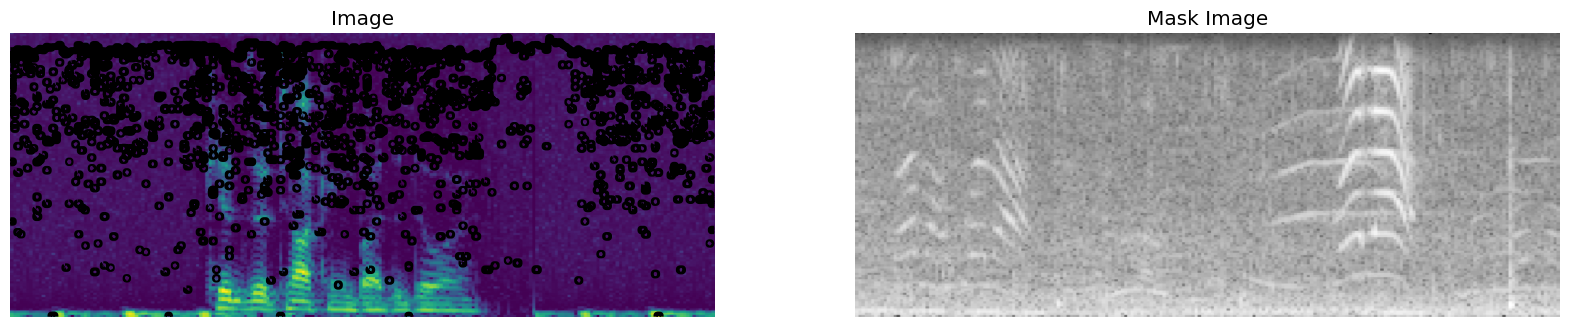

In [12]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Image')
ax2.set_axis_off()

In [13]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
# valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [14]:
print(np.unique(y_train))
print(np.unique(y_test))


[0.11764706 0.11982922 0.11986085 ... 0.8430424  0.8430898  0.84313726]
[0.11764706 0.12156863 0.12504743 ... 0.8427261  0.842995   0.84313726]


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import gc

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same')(input_tensor)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same')(x)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def Unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    u6 = Conv2DTranspose(n_filters * 8, (2, 2), strides=(2, 2), padding='same')(c5)
    if u6.shape[1] != c4.shape[1]:
        u6 = ZeroPadding2D(((0, 1), (0, 0)))(u6)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (2, 2), strides=(2, 2), padding='same')(c6)
    if u7.shape[1] != c3.shape[1]:
        u7 = ZeroPadding2D(((0, 1), (0, 0)))(u7)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (2, 2), strides=(2, 2), padding='same')(c7)
    if u8.shape[1] != c2.shape[1]:
        u8 = ZeroPadding2D(((0, 1), (0, 0)))(u8)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (2, 2), strides=(2, 2), padding='same')(c8)
    if u9.shape[1] != c1.shape[1]:
        u9 = ZeroPadding2D(((0, 1), (0, 0)))(u9)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Custom metric for segmentation: Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load your data
X = np.load('Usage1.npy')
y = np.load('Usage2.npy')

# Binarize the labels
y_bin = (y > 0.5).astype(np.float32)

# Split your data into training and testing sets
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.1, random_state=42)
print(X_train.shape, y_train_bin.shape, X_test.shape, y_test_bin.shape)

# Collect garbage
gc.collect()

# Adjust input shape to match your image dimensions
input_img = Input(shape=(400, 992, 3))  
model = Unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)

# Compile the model with the Dice coefficient as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])

# Fit the model
results = model.fit(X_train, y_train_bin, batch_size=6, epochs=5, validation_data=(X_test, y_test_bin))

# Print results
print(results)


(636, 400, 992, 3) (636, 400, 992, 1) (71, 400, 992, 3) (71, 400, 992, 1)
Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 586s 5s/step - dice_coefficient: 0.7214 - loss: 0.5555 - val_dice_coefficient: 0.5568 - val_loss: 1.2883
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 551s 5s/step - dice_coefficient: 0.8297 - loss: 0.3893 - val_dice_coefficient: 0.8050 - val_loss: 0.4276
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 539s 5s/step - dice_coefficient: 0.8401 - loss: 0.3822 - val_dice_coefficient: 0.8210 - val_loss: 0.4117
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 546s 5s/step - dice_coefficient: 0.8521 - loss: 0.3635 - val_dice_coefficient: 0.8330 - val_loss: 0.4278
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - dice_coefficient: 0.8519 - loss: 0.3713 - val_dice_coefficient: 0.8311 - val_loss: 0.4193


In [16]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
# from tensorflow.keras.models import Model

# def Unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
#     """Function to define the UNET Model"""
#     # Contracting Path
#     c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
#     p1 = MaxPooling2D((2, 2))(c1)
#     p1 = Dropout(dropout)(p1)

#     c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
#     p2 = MaxPooling2D((2, 2))(c2)
#     p2 = Dropout(dropout)(p2)

#     c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
#     p3 = MaxPooling2D((2, 2))(c3)
#     p3 = Dropout(dropout)(p3)

#     c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
#     p4 = MaxPooling2D((2, 2))(c4)
#     p4 = Dropout(dropout)(p4)

#     c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

#     # Expansive Path
#     u6 = Conv2DTranspose(n_filters * 8, (2, 2), strides=(2, 2), padding='valid')(c5)  # Adjusted stride and padding
#     u6 = concatenate([u6, c4])
#     u6 = Dropout(dropout)(u6)
#     c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

#     u7 = Conv2DTranspose(n_filters * 4, (2, 2), strides=(2, 2), padding='valid')(c6)  # Adjusted stride and padding
#     u7 = concatenate([u7, c3])
#     u7 = Dropout(dropout)(u7)
#     c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

#     u8 = Conv2DTranspose(n_filters * 2, (2, 2), strides=(2, 2), padding='valid')(c7)  # Adjusted stride and padding
#     u8 = concatenate([u8, c2])
#     u8 = Dropout(dropout)(u8)
#     c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

#     u9 = Conv2DTranspose(n_filters * 1, (2, 2), strides=(2, 2), padding='valid')(c8)  # Adjusted stride and padding
#     u9 = concatenate([u9, c1])
#     u9 = Dropout(dropout)(u9)
#     c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
#     model = Model(inputs=[input_img], outputs=[outputs])
#     return model

# # Example usage:
# input_img = Input(shape=(1000, 400, 1))  # Define input shape suitable for your images
# model = Unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)
# model.summary()


In [32]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = [
    "accuracy",
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),
    tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity')
]

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

7229

In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 400, 992,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 992,  │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 992,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 400, 992,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 400, 992,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 992,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 992,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 496,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 496,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 496,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 496,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 200, 496,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 200, 496,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 496,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 200, 496,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 248,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 248,  │          0 │ max_pooling2d_1[

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [34]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [35]:
print(model)

<Functional name=functional, built=True>


In [36]:
type(X_train)

numpy.ndarray

In [37]:
import tensorflow.experimental.numpy as tnp

tnp.experimental_enable_numpy_behavior()


In [38]:
# results = model.fit(X_train, y_train, batch_size=6, epochs=5, validation_data=(X_test, y_test))

In [39]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,dice_coefficient,loss,val_dice_coefficient,val_loss
2,0.842244,0.383155,0.821043,0.411666
4,0.848866,0.376266,0.831091,0.419272
1,0.833480,0.387983,0.804989,0.427621
3,0.846671,0.378930,0.832994,0.427813
0,0.775714,0.464402,0.556811,1.288337


In [40]:
print(results.history.keys())


dict_keys(['dice_coefficient', 'loss', 'val_dice_coefficient', 'val_loss'])


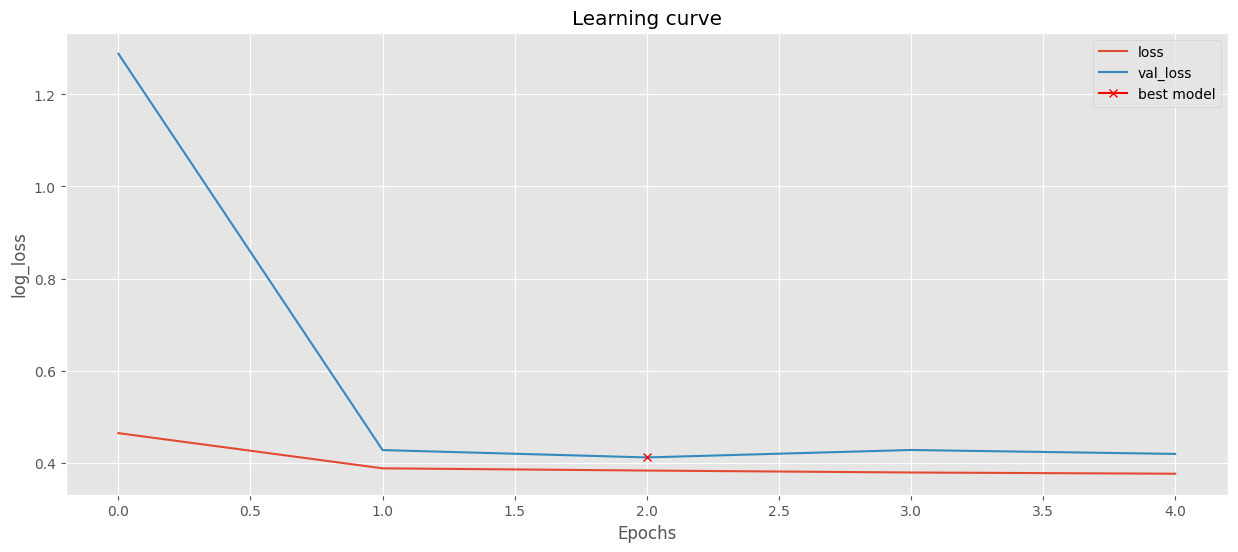

In [43]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# plt.figure(figsize = (15,6))
# plt.title("Learning curve")
# plt.plot(results.history["accuracy"], label="Accuracy")
# plt.plot(results.history["val_accuracy"], label="val_Accuracy")
# plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend();

# **Inference**

In [44]:
# model.load_weights('model-Unet.h5')

In [45]:
model.evaluate(X_test, y_test, verbose=1)
accuracy = model.evaluate(X_test, y_test, batch_size=2, verbose=1)
print(accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.6998 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 387ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.6996 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00
[0.6998496055603027, 0.0, 0.0, 0.0, 0.0]


In [46]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [47]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [48]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Predicted')
    ax[1].set_axis_off()


# **Predictions on training set**

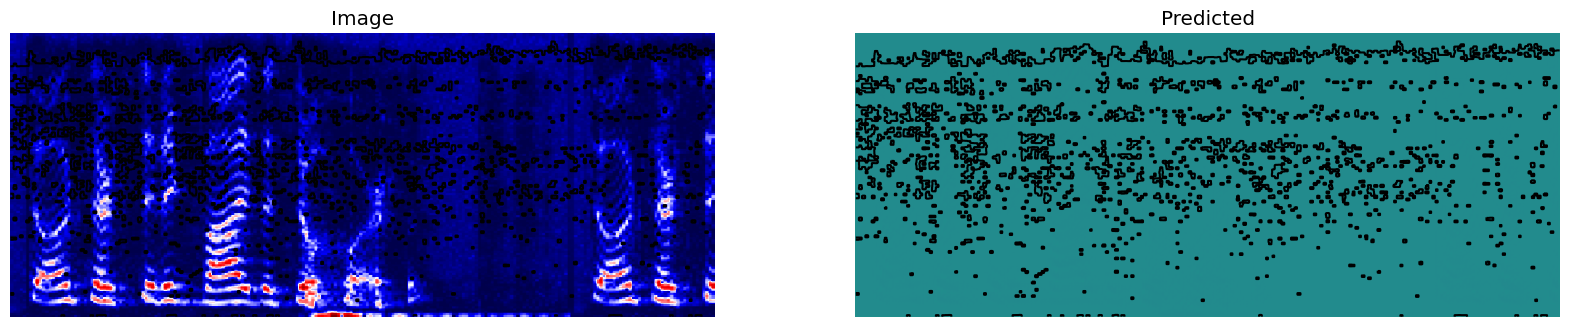

In [49]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

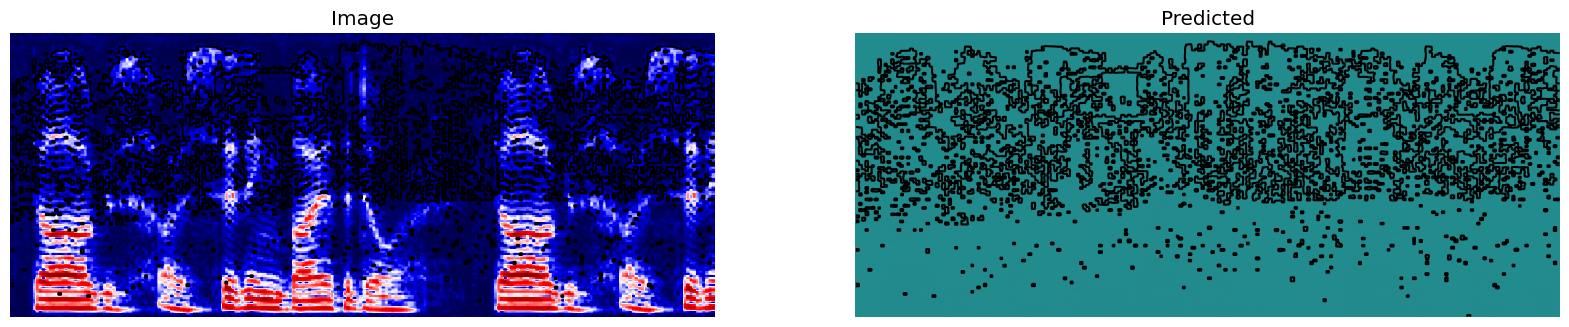

In [50]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

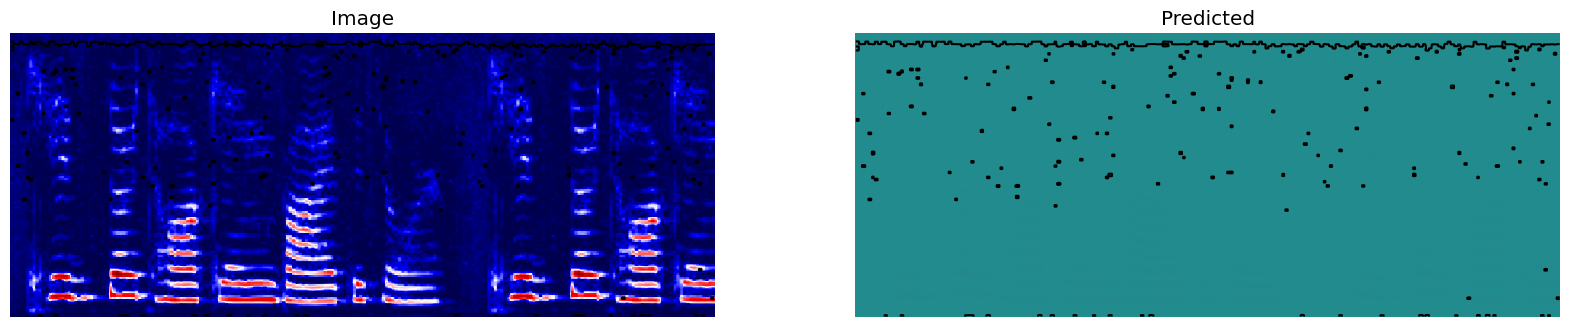

In [51]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

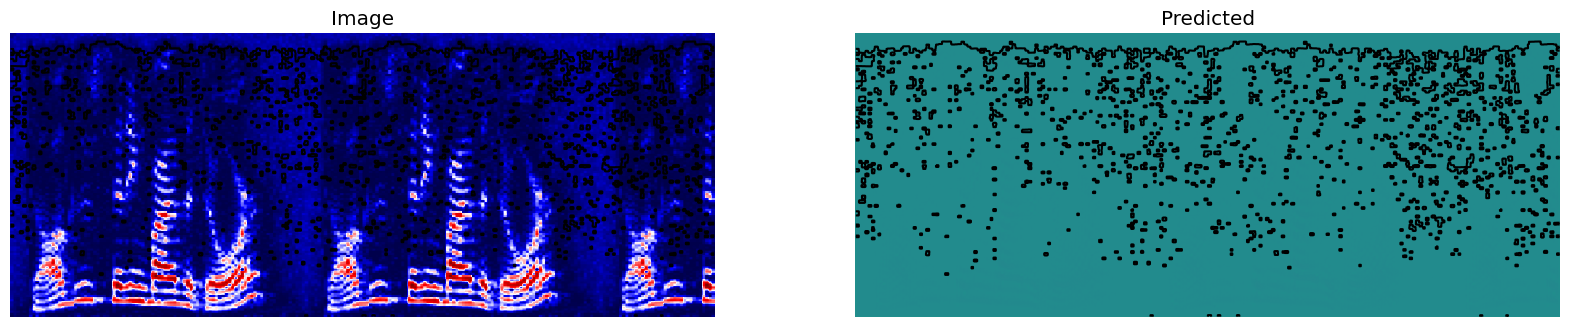

In [52]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

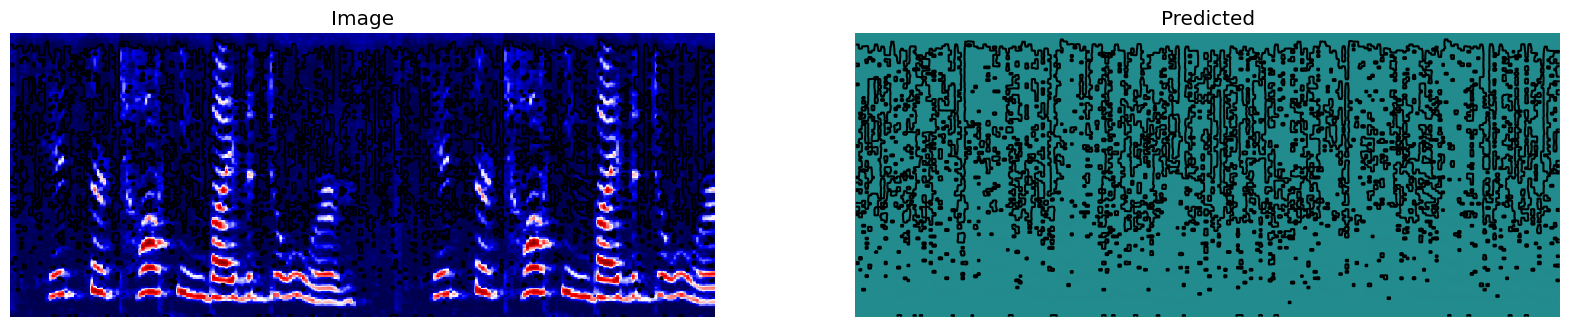

In [53]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

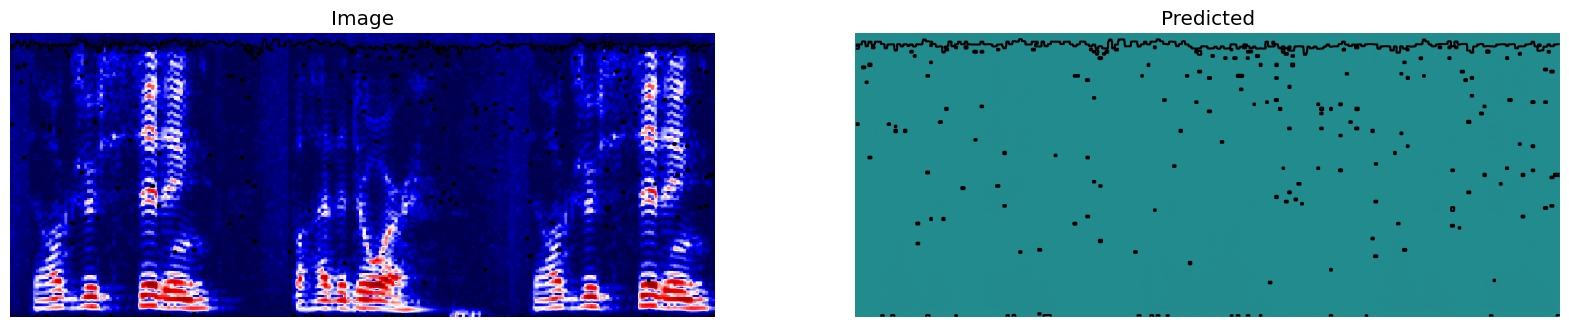

In [54]:
plot_sample(X_train, y_train, preds_train, preds_train_t)